# Project : Speaker Adaptation for Speech-to-Speech Translation (Cascaded Pipeline)


In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch

import torchaudio
try:
    torchaudio.set_audio_backend("soundfile")
except Exception:
    pass
if not hasattr(torchaudio, "list_audio_backends"):
    torchaudio.list_audio_backends = lambda: ["soundfile"]
from speechbrain.inference.speaker import EncoderClassifier


#### Load and Setup Data

In [2]:
from datasets import Audio, load_dataset

class VoxPopuliDataset:
    def __init__(
        self,
        load_spanish_accent: bool = False,
        *,
        split: str = "validation",
        streaming: bool = True,
        cache_dir: str = "data/voxpopuli_en",
        sampling_rate: int = 16000,
    ):
        self.streaming = streaming
        self.sampling_rate = sampling_rate

        if load_spanish_accent:
            print("Loading Spanish Accent Dataset...")
            self.en_ds = load_dataset(
                path="facebook/voxpopuli",
                name="en_accented",
                cache_dir="data/voxpopuli_acceented",
                split=split,
                streaming=streaming,
            )
        else:
            print("Loading English Dataset...")
            self.en_ds = load_dataset(
                "facebook/voxpopuli",
                "en",
                split=split,
                cache_dir=cache_dir,
                streaming=streaming,
            )

        self.en_ds = self.en_ds.cast_column("audio", Audio(sampling_rate=self.sampling_rate))

        first = next(iter(self.en_ds))
        print("First instance:", first)

    def filter_accented(self) -> None:
        """Filters the dataset to only include accented Spanish speakers."""
        self.en_ds = self.en_ds.filter(lambda x: x.get("accent") == "spanish")

    def iter_examples(self):
        """Streaming-safe iterator over examples."""
        return iter(self.en_ds)

    def get_rows_speaker_id(self, max_examples: int = 50_000, min_count: int = 32) -> None:
        """Counts speaker_id frequency.

        NOTE: On streaming datasets, this scans the stream; use max_examples to cap work.
        """
        from collections import defaultdict
        import itertools
        import matplotlib.pyplot as plt

        speaker_counts = defaultdict(int)

        for example in itertools.islice(self.en_ds, max_examples):
            speaker_id = example.get("speaker_id")
            if speaker_id is not None:
                speaker_counts[speaker_id] += 1

        plt.figure()
        plt.hist(speaker_counts.values(), bins=20)
        plt.ylabel("Speakers")
        plt.xlabel("Examples")
        plt.show()

        for speaker_id, count in speaker_counts.items():
            if count >= min_count:
                print(f"Speaker {speaker_id} has {count} examples")



In [3]:
import os
import itertools

import numpy as np
import soundfile as sf
import torch
from torch.utils.data import DataLoader, IterableDataset


class VoxPopuliSpeakerIterableDataset(IterableDataset):
    """Streaming-friendly dataset that filters by speaker_id and trims audio at load time.

    If save_dir is provided, writes trimmed WAVs to disk and rewrites audio['path'] so downstream
    code can keep using torchaudio.load(audio_path).
    """

    def __init__(
        self,
        hf_iterable_dataset,
        *,
        selected_speaker_id,
        audio_duration_sec: int = 10,
        sampling_rate: int = 16000,
        max_rows: int | None = 64,
        save_dir: str | None = None,
    ):
        super().__init__()
        self.hf_ds = hf_iterable_dataset
        self.selected_speaker_id = str(selected_speaker_id)
        self.audio_duration_sec = int(audio_duration_sec)
        self.sampling_rate = int(sampling_rate)
        self.max_rows = max_rows
        self.save_dir = save_dir

        self.target_num_samples = self.audio_duration_sec * self.sampling_rate

        if self.save_dir is not None:
            os.makedirs(self.save_dir, exist_ok=True)

    def __iter__(self):
        n_yielded = 0

        for ex in self.hf_ds:
            speaker_id = ex.get("speaker_id")
            if speaker_id is None:
                continue
            if str(speaker_id) != self.selected_speaker_id:
                continue

            audio = ex.get("audio")
            if not audio or "array" not in audio:
                continue

            sr = int(audio.get("sampling_rate", self.sampling_rate))
            if sr != self.sampling_rate:
                continue

            arr = audio["array"]
            if arr is None:
                continue

            arr = np.asarray(arr, dtype=np.float32)
            if arr.ndim > 1:
                arr = arr.squeeze()
            if arr.ndim != 1:
                continue

            if arr.shape[0] < self.target_num_samples:
                continue

            trimmed = arr[: self.target_num_samples]

            if self.save_dir is not None:
                audio_id = ex.get("audio_id") or ex.get("id") or f"row_{n_yielded}"
                out_path = os.path.join(self.save_dir, f"{audio_id}.wav")
                sf.write(out_path, trimmed, self.sampling_rate)
                ex["audio"] = {"path": out_path, "array": trimmed, "sampling_rate": self.sampling_rate}
            else:
                ex["audio"] = {"path": audio.get("path"), "array": trimmed, "sampling_rate": self.sampling_rate}

            yield ex
            n_yielded += 1

            if self.max_rows is not None and n_yielded >= self.max_rows:
                break


class SpeakerDataloader:
    """Helper to build a DataLoader for a single VoxPopuli speaker in streaming mode."""

    def __init__(
        self,
        *,
        selected_speaker_id,
        audio_duration: int = 10,
        batch_size: int = 16,
        dataset,
        max_rows: int | None = 64,
        save_to: str | None = None,
    ):
        if dataset is None:
            raise ValueError("Dataset must be provided.")

        hf_ds = dataset.en_ds if hasattr(dataset, "en_ds") else dataset

        if save_to is None:
            save_to = f"data/speaker_{selected_speaker_id}"

        self.dataset = VoxPopuliSpeakerIterableDataset(
            hf_ds,
            selected_speaker_id=selected_speaker_id,
            audio_duration_sec=audio_duration,
            sampling_rate=16000,
            max_rows=max_rows,
            save_dir=save_to,
        )

        self.dataloader = DataLoader(
            self.dataset,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=lambda batch: batch,
        )


In [4]:
import whisper
import os

class ASRModel():
    """
    Helper class to load the ASR model.
    """
    def __init__(self):
        self.model = whisper.load_model(name="large-v3-turbo")
        self.samplerate = 16000

    def transcribe(self, audio_path: str, language: str = None) -> str:
        """Transcribes audio file to text."""
        if not os.path.exists(audio_path):
            raise FileNotFoundError(f"Audio file not found: {audio_path}")

        result = self.model.transcribe(audio_path, language=language)
        return result["text"].strip()
    

In [5]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from googletrans import Translator

class TranslationModel:
    """
    Helper class to load the translation model.
    """
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-large")
        self.model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-large")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.translator = Translator()

    def translate(self, text: str, target_language: str = "es") -> str:
        text = text.replace("...", "")
        if target_language.lower() in ("es", "spanish"):
            text = f"translate English to Spanish: {text}"
        else:
            text = f"translate Spanish to English: {text}"
        tokenized_input = self.tokenizer(text, return_tensors="pt").to(self.device)
        outputs = self.model.generate(**tokenized_input, max_new_tokens=256)
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)


In [6]:
class SpeechEmbeddingsService:
    """
    Helper class to load the speech embeddings model.
    """
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.speaker_model = EncoderClassifier.from_hparams(
            source="speechbrain/spkrec-xvect-voxceleb", 
            savedir="tmp_model",
            run_opts={"device": "cpu"} 
        )
    
    def extract_embedding(self, audio_path: str) -> torch.Tensor:
        """Extracts speaker embedding from audio file."""
        audio, sr = torchaudio.load(audio_path)
        audio = audio.to(self.device)
        embedding = self.speaker_model.encode_batch(audio)
        emb_tensor = torch.tensor(embedding) if not isinstance(embedding, torch.Tensor) else embedding
        emb_tensor = emb_tensor.squeeze()
        return emb_tensor.to(self.device)

    

In [7]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.nn.functional import cosine_similarity
import warnings

class EvaluationService:
    """
    Helper class to evaluate the performance of the speech-to-speech translation model.
    Two main metrics we check. BLEU score and Cosine Similarity between embeddings.
    """
    def __init__(self):
        warnings.filterwarnings("ignore")


    def evaluate_bleu(self, reference: str, candidate: str) -> float:
        reference_tokens = self.__tokenize_sentence_for_bleu(reference)
        candidate_tokens = self.__tokenize_sentence_for_bleu(candidate)

        # sentence_bleu(references, hypothesis)
        smoothie = SmoothingFunction().method1
        return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothie)

    def evaluate_cosine_similarity(
        self,
        reference_embedding: torch.Tensor,
        candidate_embedding: torch.Tensor,
    ) -> float:
        ref = reference_embedding.reshape(-1).float()
        cand = candidate_embedding.reshape(-1).float()

        # (optional safety)
        if ref.numel() != cand.numel():
            raise ValueError(f"Embedding size mismatch: {ref.shape} vs {cand.shape}")

        return cosine_similarity(ref, cand, dim=0).item()

    def __tokenize_sentence_for_bleu(self, sentence: str) -> list[str]:
        """
        Tokenizes the sentence for BLEU score calculation.
        """
        return sentence.split()
    

In [8]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
import soundfile as sf
import torch
import tqdm


class TTSService:
    """Helper class to load the TTS model."""

    def __init__(self):
        self.model_name = "microsoft/speecht5_tts"
        self.vocoder_name = "microsoft/speecht5_hifigan"
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.embedding_service = SpeechEmbeddingsService()

        # Load TTS models
        self.processor = SpeechT5Processor.from_pretrained(self.model_name)
        self.model = SpeechT5ForTextToSpeech.from_pretrained(self.model_name).to(self.device)
        self.vocoder = SpeechT5HifiGan.from_pretrained(self.vocoder_name).to(self.device)

    def synthesize(self, text: str, output_file_path: str, speaker_audio_path: str) -> str:
        """Synthesizes text to speech using style from `speaker_audio_path`."""
        inputs = self.processor(text=text, return_tensors="pt").to(self.device)
        speaker_embeddings = self.embedding_service.extract_embedding(speaker_audio_path).to(self.device)
        if speaker_embeddings.dim() == 1:
            speaker_embeddings = speaker_embeddings.unsqueeze(0)
        with torch.no_grad():
            speech = self.model.generate_speech(
                inputs["input_ids"],
                speaker_embeddings,
                vocoder=self.vocoder,
            )

        sf.write(output_file_path, speech.cpu().numpy(), samplerate=16000)
        return output_file_path

    def load_model_finetuned(self, model_path: str, processor_path: str):
        self.model = SpeechT5ForTextToSpeech.from_pretrained(model_path)
        self.processor = SpeechT5Processor.from_pretrained(processor_path)


In [9]:
EXPERIEMENT_SPEAKER_IDS = [1055, 28165, 124992]
DURATIONS = [2, 4, 6, 8, 10]

In [53]:
import random
from datasets import load_dataset
import string

class EnglishSpanishSPDataset:
    def __init__(self, *, min_words=3, max_words=25, seed=21):
        self.ds = load_dataset(
            "Helsinki-NLP/opus-100",
            "en-es",
            split="validation",
            cache_dir="data/opus-100-SP",
        )

        self.seed = seed
        random.seed(self.seed)

        # keep short-ish sentences so SpeechT5 doesn't crash on very long inputs
        def ok_len(x):
            en = x["translation"]["en"].split()
            es = x["translation"]["es"].split()
            return (min_words <= len(en) <= max_words) and (min_words <= len(es) <= max_words)

        def no_special_characters(x):
            return all(c in string.printable for c in x["translation"]["en"]) and all(c in string.printable for c in x["translation"]["es"])

        self.ds = self.ds.filter(ok_len).filter(no_special_characters)

    def get_5_pairs(self, k=5):
        n = len(self.ds)
        if n == 0:
            raise ValueError("No examples left after filtering. Loosen min_words/max_words.")

        # Always pick the first k examples to ensure deterministic output
        k = min(k, n)
        pairs = []
        for i in range(k):
            t = self.ds[i]["translation"]
            pairs.append((t["en"], t["es"]))
        return pairs

    def get_5_random_pairs(self, k=5):
        n = len(self.ds)
        if n == 0:
            raise ValueError("No examples left after filtering. Loosen min_words/max_words.")

        k = min(k, n)
        # Always pick the first k pairs after shuffling deterministically with the seed
        pairs = [(ex["translation"]["en"], ex["translation"]["es"]) for ex in self.ds]
        random_state = random.getstate()  # save the current random state
        random.seed(self.seed)  # ensure deterministic shuffle
        random.shuffle(pairs)
        random.setstate(random_state)  # restore the random state
        return pairs[:k]

    def get_20_random_pairs(self, k=20):
        n = len(self.ds)
        if n == 0:
            raise ValueError("No examples left after filtering. Loosen min_words/max_words.")

        # Always pick the first k examples to ensure deterministic output
        k = min(k, n)
        pairs = []
        for i in range(k):
            t = self.ds[i]["translation"]
            pairs.append((t["en"], t["es"]))
        return pairs

***

### Experiement with Zero_Shot prompting embeddings

In [11]:
import json
import tqdm
import pandas as pd
import shutil

class ExperiementZeroShot:
    """
    Helper class to run the experiement for zero-shot speech-to-speech translation.
    """
    def __init__(self, speaker_ids: list[str]):
        self.voxpopuli_dataset = VoxPopuliDataset(streaming=True)
        self.speaker_ids = speaker_ids
        self.asr_model = ASRModel()
        self.translation_model = TranslationModel()
        self.tts_service = TTSService()
        self.evaluation_service = EvaluationService()
        self.source_language = "en"
        self.target_language = "es"
        self.embedding_service = SpeechEmbeddingsService()
        self.output_dir = "results/zero_shot"
        self.english_spanish_sp_dataset = EnglishSpanishSPDataset()

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def run(self, samples: int = 5):
        for speaker_id in self.speaker_ids:
            print(f"Running experiement for speaker {speaker_id}")
            results = {}

            for duration in DURATIONS:
                print(f"Running experiement for duration {duration} seconds")

                loader = SpeakerDataloader(
                    selected_speaker_id=speaker_id,
                    dataset=self.voxpopuli_dataset,
                    audio_duration=duration,
                    batch_size=samples,
                    max_rows=samples,
                ).dataloader

                blue_scores = []
                cosine_similarities = []

                for batch in loader:
                    counter = 0
                    for row in batch:
                        counter += 1
                        if counter > samples:
                            break
                        source_audio = row["audio"]["path"]
                        source_embedding = self.embedding_service.extract_embedding(source_audio)

                        for en_text, es_text in self.english_spanish_sp_dataset.get_5_pairs():
                            print(f"Running experiement for {en_text} and {es_text}")
                            output_spanish_audio = self.tts_service.synthesize(es_text, "output/temp.wav", source_audio)
                            transcribed_spanish_audio = self.asr_model.transcribe(output_spanish_audio, self.target_language)
                            backtranslated_text = self.translation_model.translate(transcribed_spanish_audio, self.source_language)
                            print(f"Backtranslated text: {backtranslated_text}")
                            bleu_score = self.evaluation_service.evaluate_bleu(es_text, backtranslated_text)

                            output_spanish_audio_embedding = self.embedding_service.extract_embedding(output_spanish_audio)
                            cosine_similarity = self.evaluation_service.evaluate_cosine_similarity(
                                source_embedding, output_spanish_audio_embedding
                            )

                            blue_scores.append(bleu_score)
                            cosine_similarities.append(cosine_similarity)

                        if counter == 1:
                            #lets save a sample input, and sample output
                            sample_input = {
                                "source_audio": source_audio,
                                "source_text": en_text,
                                "target_text": es_text,
                                "output_spanish_audio": output_spanish_audio,
                                "backtranslated_text": backtranslated_text,
                            }
                            folder = f"{self.output_dir}/speaker_{speaker_id}/duration_{duration}"
                            if not os.path.exists(folder):
                                os.makedirs(folder)
                            with open(f"{folder}/sample_input.json", "w") as f:
                                json.dump(sample_input, f)
                            #move the source audio to the folder
                            shutil.copy(source_audio, f"{folder}/source_audio.wav")
                            #move the output spanish audio to the folder
                            shutil.copy(output_spanish_audio, f"{folder}/output_spanish_audio.wav")

                results[duration] = {
                    "bleu_score": sum(blue_scores) / len(blue_scores),
                    "cosine_similarity": sum(cosine_similarities) / len(cosine_similarities),
                }

            print(results)
            #turn results into a dataframe
            results_df = pd.DataFrame(results)
            results_df.to_csv(f"results/zero_shot/results_{speaker_id}.csv")

In [12]:
# experiement = ExperiementZeroShot(EXPERIEMENT_SPEAKER_IDS)
# experiement.run()

***

## Fine Tuning

##### Load Dataset

In [89]:
# import itertools
# from datasets import load_dataset, Dataset, Audio

# stream = load_dataset("facebook/voxpopuli", "en", split="validation", streaming=True, cache_dir="data/voxpopuli_en_validation_3speakers")
# stream = stream.cast_column("audio", Audio(sampling_rate=16000))
# allowed = [str(1055), str(28165), str(124992)]

# filtered_iter = (x for x in stream if str(x.get("speaker_id")) in allowed)
# rows = list(filtered_iter)  # take all rows
# ds_small = Dataset.from_list(rows)
# print(f"Found len {len(rows)}")
# ds_small.save_to_disk("data/voxpopuli_en_validation_3speakers")

In [566]:
selected_speaker_id = 28165

In [567]:
import itertools
from datasets import load_dataset, Dataset, Audio
from datasets import load_from_disk

dataset = load_from_disk("data/voxpopuli_en_validation_3speakers")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))


##### Preprocess Data

In [568]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

In [569]:
tokenizer = processor.tokenizer

In [570]:
dataset[0]

{'audio_id': '20180612-0900-PLENARY-19-en_20180612-20:44:15_13',
 'language': 0,
 'audio': {'path': None,
  'array': array([-2.44140625e-04, -2.13623047e-04, -1.52587891e-04, ...,
         -6.10351562e-05, -1.52587891e-04, -2.13623047e-04], shape=(145600,)),
  'sampling_rate': 16000},
 'raw_text': 'If corruption is not addressed drastically, MFA funds should not be delivered to Ukraine.',
 'normalized_text': 'if corruption is not addressed drastically mfa funds should not be delivered to ukraine.',
 'gender': 'male',
 'speaker_id': '1055',
 'is_gold_transcript': False,
 'accent': 'None'}

In [571]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/112 [00:00<?, ? examples/s]

In [572]:
print(dataset_vocab)

{'q', '?', '.', 'o', ';', 'f', 'n', 'u', 'b', 'e', 'y', 'h', 't', 'v', '!', 'i', 'l', 'w', "'", 'p', 'r', 'x', 'j', ' ', 'a', 'k', 'm', 'c', 'g', 'z', 's', 'd'}


In [573]:
replacements = [
    ("à", "a"),
    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("í", "i"),
    ("ï", "i"),
    ("ö", "o"),
    ("ü", "u"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

In [574]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

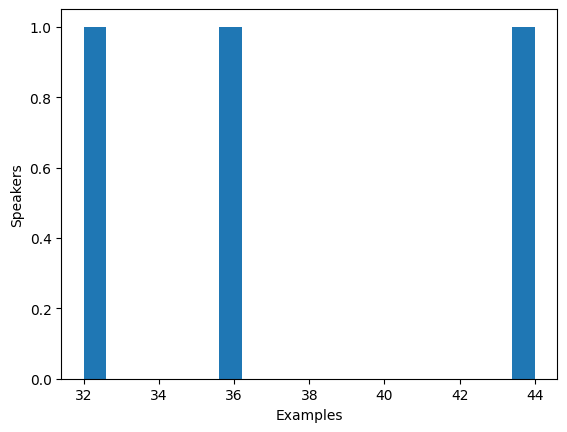

In [575]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [576]:
def select_speaker(speaker_id):
    return int(speaker_id) == selected_speaker_id


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

In [577]:
print(dataset[0])

{'audio_id': '20180910-0900-PLENARY-en_20180910-20:02:21_9', 'language': 0, 'audio': {'path': None, 'array': array([0.00411987, 0.00396729, 0.00408936, ..., 0.00039673, 0.00042725,
       0.00018311], shape=(130879,)), 'sampling_rate': 16000}, 'raw_text': 'And he did his job, two years later, three years later to see what comes out. And the conclusion is clear the work was fixed, the work was done.', 'normalized_text': 'and he did his job two years later three years later to see what comes out. and the conclusion is clear the work was fixed the work was done.', 'gender': 'male', 'speaker_id': '28165', 'is_gold_transcript': False, 'accent': 'None'}


In [578]:
len(set(dataset["speaker_id"]))

1

In [579]:
#remove rows that have no audio or audio is too short
dataset = dataset.filter(lambda x: x["audio"]["array"] is not None and len(x["audio"]["array"]) > 0)
len(dataset)


44

##### Speaker Embeddings

In [580]:
import os
import torch
from speechbrain.inference.speaker import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

##### Processing Dataset

In [581]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [582]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

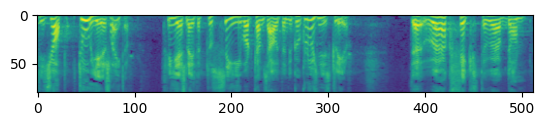

In [583]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [584]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

In [585]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

41

In [586]:
dataset = dataset.train_test_split(test_size=0.1)

In [587]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        if (batch["labels"] == -100).all():
            raise ValueError("All labels are ignored (-100). Likely empty/too-short label features in this batch.")

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [588]:
data_collator = TTSDataCollatorWithPadding(processor=processor)


##### Fine Tune Model

In [589]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [590]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [597]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir=f"speecht5_finetuned_voxpopuli_speaker_{selected_speaker_id}",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=.000001,
    warmup_steps=1,
    max_steps=20,
    gradient_checkpointing=False,
    fp16=False,
    eval_strategy="steps",
    per_device_eval_batch_size=4,
    save_steps=100000,
    eval_steps=10,
    logging_steps=5,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=False,
)

In [598]:
from transformers import Seq2SeqTrainer

model.config.use_cache = False

print(len(dataset["train"]))
print(len(dataset["test"]))

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

36
5


In [599]:
for p in model.speecht5.encoder.parameters():
    p.requires_grad = False

trainer.train()

Step,Training Loss,Validation Loss
10,0.716000,0.665280
20,0.763200,0.658157


TrainOutput(global_step=20, training_loss=0.7314075112342835, metrics={'train_runtime': 14.8079, 'train_samples_per_second': 21.61, 'train_steps_per_second': 1.351, 'total_flos': 34096387647168.0, 'train_loss': 0.7314075112342835, 'epoch': 6.8})

In [594]:
raise Exception("Stop here")

Exception: Stop here

In [600]:
model.save_pretrained(f"models/finetuned_models/speecht5_finetuned_voxpopuli_speaker_{selected_speaker_id}")
processor.save_pretrained(f"models/finetuned_models/speecht5_finetuned_voxpopuli_speaker_{selected_speaker_id}")

[]

In [601]:
#test model
example_sentence = "Today has been a really good day."
example_sentence_2 = "Hola mi nombre is Jose y me encanta jugar futbol"

print(f"Testing for model speaker {selected_speaker_id}")

#make output audio here
processor.from_pretrained(f"models/finetuned_models/speecht5_finetuned_voxpopuli_speaker_{selected_speaker_id}")
model.from_pretrained(f"models/finetuned_models/speecht5_finetuned_voxpopuli_speaker_{selected_speaker_id}")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
vocoder = vocoder.to(device)

reference_audio = f'results/zero_shot/speaker_{selected_speaker_id}/duration_10/source_audio.wav'
embeddings_service = SpeechEmbeddingsService()

waveform, sr = torchaudio.load(reference_audio)   # waveform: (channels, time)
waveform = waveform.mean(dim=0)                   # -> (time,) mono
waveform = waveform.unsqueeze(0)   
speaker_embeddings = create_speaker_embedding(waveform)
speaker_embeddings = torch.tensor(speaker_embeddings, dtype=torch.float32).to(device)

if speaker_embeddings.dim() == 1:
    speaker_embeddings = speaker_embeddings.unsqueeze(0)

inputs = processor(text=example_sentence_2, return_tensors="pt").to(device)

output_file_path = "output/demo_output.wav"

with torch.no_grad():
    speech = model.generate_speech(
        inputs["input_ids"],
        speaker_embeddings=speaker_embeddings,
        vocoder=vocoder,
    )

    sf.write(output_file_path, speech.cpu().numpy(), samplerate=16000)

print(f"Generated speech saved to {output_file_path}")


Testing for model speaker 28165
Generated speech saved to output/demo_output.wav


***

### Evaluate and Compare Systems

In [ ]:
speaker_one = 1055
speaker_two = 28165
speaker_three = 124992

In [ ]:
en_es_dataset = EnglishSpanishSPDataset()
five_random_sentence_pairs = en_es_dataset.get_5_random_pairs()
twenty_random_sentence_pairs = en_es_dataset.get_20_random_pairs()

print(five_random_sentence_pairs)

[('Goes by Crumbs.', 'Se hace llamar Crumbs.'), ('Gladdie, of course.', 'Gladdie, por supuesto.'), ('Now, before you give us an answer, I want to impress you with three things.', 'Antes de darnos una respuesta, quiero que sepa tres cosas.'), ("It's almost time for school.", 'Es casi la hora de ir a la escuela.'), ("Don't think you will be able to destroy me that easily.", 'No creas que puedes acabar conmigo.')]


In [ ]:
tts_base = TTSService()

fine_tuned_tts_speaker_one = TTSService()
fine_tuned_tts_speaker_one.load_model_finetuned(model_path=f"models/finetuned_models/speecht5_finetuned_voxpopuli_speaker_{speaker_one}", processor_path=f"models/finetuned_models/speecht5_finetuned_voxpopuli_speaker_{speaker_one}")

fine_tuned_tts_speaker_two = TTSService()
fine_tuned_tts_speaker_two.load_model_finetuned(model_path=f"models/finetuned_models/speecht5_finetuned_voxpopuli_speaker_{speaker_two}", processor_path=f"models/finetuned_models/speecht5_finetuned_voxpopuli_speaker_{speaker_two}")

fine_tuned_tts_speaker_three = TTSService()
fine_tuned_tts_speaker_three.load_model_finetuned(model_path=f"models/finetuned_models/speecht5_finetuned_voxpopuli_speaker_{speaker_three}", processor_path=f"models/finetuned_models/speecht5_finetuned_voxpopuli_speaker_{speaker_three}")


In [ ]:
asr_model = ASRModel()
translation_model = TranslationModel()
evaluation_service = EvaluationService()
embeddings_service = SpeechEmbeddingsService()

***

### Quantitative Comparison

##### Speaker 1

In [ ]:
import pandas as pd

# zero shot vs fine tuned, speaker one
reference_audio = f'results/zero_shot/speaker_{speaker_one}/duration_10/source_audio.wav'
speaker_embeddings = embeddings_service.extract_embedding(reference_audio)

speaker_one_df = pd.DataFrame()

for en, es in twenty_random_sentence_pairs:
    print("---")
    print(f"English: {en}")
    print(f"Spanish: {es}")

    # zero shot
    zero_shot_audio = tts_base.synthesize(es, "output/temp_zero_shot.wav", reference_audio)
    zero_shot_embeddings = embeddings_service.extract_embedding(zero_shot_audio)
    zero_shot_transcribed_audio = asr_model.transcribe(zero_shot_audio, "es")
    zero_shot_blue = evaluation_service.evaluate_bleu(es, zero_shot_transcribed_audio)
    zero_shot_cosine = evaluation_service.evaluate_cosine_similarity(zero_shot_embeddings, speaker_embeddings)
    print(f"Zero Shot es text: {zero_shot_transcribed_audio}")

    # fine tuned
    fine_tuned_audio = fine_tuned_tts_speaker_one.synthesize(es, "output/temp_fine_tuned.wav", reference_audio)
    fine_tuned_embeddings = embeddings_service.extract_embedding(fine_tuned_audio)
    fine_tuned_transcribed_audio = asr_model.transcribe(fine_tuned_audio, "es")
    fine_tuned_blue = evaluation_service.evaluate_bleu(es, fine_tuned_transcribed_audio)
    fine_tuned_cosine = evaluation_service.evaluate_cosine_similarity(fine_tuned_embeddings, speaker_embeddings)
    print(f"Fine Tuned es text: {fine_tuned_transcribed_audio}")

    # add results to dataframe
    speaker_one_df = pd.concat([speaker_one_df, pd.DataFrame({
        "English": [en],
        "Spanish": [es],
        "Zero Shot BLEU": [zero_shot_blue],
        "Fine Tuned BLEU": [fine_tuned_blue],
        "Zero Shot Cosine": [zero_shot_cosine],
        "Fine Tuned Cosine": [fine_tuned_cosine],
        "Zero Shot Transcribed Audio": [zero_shot_transcribed_audio],
        "Fine Tuned Transcribed Audio": [fine_tuned_transcribed_audio]
    })])


speaker_one_df = pd.concat([speaker_one_df, pd.DataFrame({
    "English": ["Average"],
    "Spanish": ["Average"],
    "Zero Shot BLEU": [speaker_one_df["Zero Shot BLEU"].mean()],
    "Fine Tuned BLEU": [speaker_one_df["Fine Tuned BLEU"].mean()],
    "Zero Shot Cosine": [speaker_one_df["Zero Shot Cosine"].mean()],
    "Fine Tuned Cosine": [speaker_one_df["Fine Tuned Cosine"].mean()],
    "Zero Shot Transcribed Audio": ["Average"],
    "Fine Tuned Transcribed Audio": ["Average"]
})])



if not os.path.exists(f"results/comparison/speaker_{speaker_one}"):
    os.makedirs(f"results/comparison/speaker_{speaker_one}")

# save dataframe to csv
speaker_one_df.to_csv(f"results/comparison/speaker_{speaker_one}/results.csv", index=False)



---
English: You've done this before, but it's not the same...
Spanish: Lo has hecho otras veces, pero esto es diferente.
Zero Shot es text: Lo has echo otras veces, pero esto es diferente.
Fine Tuned es text: Lo has hecho otras veces, pero esto es diferente.
---
English: If it helps to have me around, even for a little bit,
Spanish: Si ayuda tenerme cerca, aunque sea un poco,
Zero Shot es text: Se genera cerca. Anxia poco.
Fine Tuned es text: Ayuda tenerem cerca Anxian poco
---
English: Mens wristwatch (2)
Spanish: Dorada (2) Correa
Zero Shot es text: Pero rather, Korea...
Fine Tuned es text: Pero rather, Korea...
---
English: WERACEDSEASONSEVENANDWON, BUT WE'RE GROWING APART.
Spanish: Nosotros competimos en la temporada 7 y ganamos pero nos hemos distanciados.
Zero Shot es text: Nosotros competimos en la temporada. Aiganamos pero nos hemos distanciados.
Fine Tuned es text: Nosotros compétimos en la temporada. Aiganamos, pero nos hicimos distanciados.
---
English: I'll be a model scho

##### Speaker 2

In [ ]:
import pandas as pd

# zero shot vs fine tuned, speaker one
reference_audio = f'results/zero_shot/speaker_{speaker_two}/duration_10/source_audio.wav'
speaker_two_df = pd.DataFrame()

for en, es in twenty_random_sentence_pairs:
    print("---")
    print(f"English: {en}")
    print(f"Spanish: {es}")

    # zero shot
    zero_shot_audio = tts_base.synthesize(es, "output/temp_zero_shot.wav", reference_audio)
    zero_shot_embeddings = embeddings_service.extract_embedding(zero_shot_audio)
    zero_shot_transcribed_audio = asr_model.transcribe(zero_shot_audio, "es")
    zero_shot_blue = evaluation_service.evaluate_bleu(es, zero_shot_transcribed_audio)
    zero_shot_cosine = evaluation_service.evaluate_cosine_similarity(zero_shot_embeddings, speaker_embeddings)
    print(f"Zero Shot es text: {zero_shot_transcribed_audio}")

    # fine tuned
    fine_tuned_audio = fine_tuned_tts_speaker_two.synthesize(es, "output/temp_fine_tuned.wav", reference_audio)
    fine_tuned_embeddings = embeddings_service.extract_embedding(fine_tuned_audio)
    fine_tuned_transcribed_audio = asr_model.transcribe(fine_tuned_audio, "es")
    fine_tuned_blue = evaluation_service.evaluate_bleu(es, fine_tuned_transcribed_audio)
    fine_tuned_cosine = evaluation_service.evaluate_cosine_similarity(fine_tuned_embeddings, speaker_embeddings)
    print(f"Fine Tuned es text: {fine_tuned_transcribed_audio}")
    # add results to dataframe
    speaker_two_df = pd.concat([speaker_two_df, pd.DataFrame({
        "English": [en],
        "Spanish": [es],
        "Zero Shot BLEU": [zero_shot_blue],
        "Fine Tuned BLEU": [fine_tuned_blue],
        "Zero Shot Cosine": [zero_shot_cosine],
        "Fine Tuned Cosine": [fine_tuned_cosine],
        "Zero Shot Transcribed Audio": [zero_shot_transcribed_audio],
        "Fine Tuned Transcribed Audio": [fine_tuned_transcribed_audio]
    })])

speaker_two_df = pd.concat([speaker_two_df, pd.DataFrame({
    "English": ["Average"],
    "Spanish": ["Average"],
    "Zero Shot BLEU": [speaker_two_df["Zero Shot BLEU"].mean()],
    "Fine Tuned BLEU": [speaker_two_df["Fine Tuned BLEU"].mean()],
    "Zero Shot Cosine": [speaker_two_df["Zero Shot Cosine"].mean()],
    "Fine Tuned Cosine": [speaker_one_df["Fine Tuned Cosine"].mean()],
    "Zero Shot Transcribed Audio": ["Average"],
    "Fine Tuned Transcribed Audio": ["Average"]
})])

if not os.path.exists(f"results/comparison/speaker_{speaker_two}"):
    os.makedirs(f"results/comparison/speaker_{speaker_two}")

# save dataframe to csv
speaker_two_df.to_csv(f"results/comparison/speaker_{speaker_two}/results.csv", index=False)

---
English: You've done this before, but it's not the same...
Spanish: Lo has hecho otras veces, pero esto es diferente.
Zero Shot es text: Lo has hecho otras veces, pero esto es diferente.
Fine Tuned es text: Lo has hecho otras species, perroesto es diferente.
---
English: If it helps to have me around, even for a little bit,
Spanish: Si ayuda tenerme cerca, aunque sea un poco,
Zero Shot es text: C.A.U. Lieutenantum Serta, och C.A.N. Poco.
Fine Tuned es text: Si ayudan en cerca. Occi en poco.
---
English: Mens wristwatch (2)
Spanish: Dorada (2) Correa
Zero Shot es text: Dorada, Korea
Fine Tuned es text: Torada, Korea.
---
English: WERACEDSEASONSEVENANDWON, BUT WE'RE GROWING APART.
Spanish: Nosotros competimos en la temporada 7 y ganamos pero nos hemos distanciados.
Zero Shot es text: Nosotros competimos en la temporada. Aigánimos pero nos hemos distanciados.
Fine Tuned es text: Nosotros compétimos en li. Ad ganamos piro nos hemos distanciados.
---
English: I'll be a model school!
Spa

##### Speaker 3

In [ ]:
import pandas as pd

# zero shot vs fine tuned, speaker one
reference_audio = f'results/zero_shot/speaker_{speaker_three}/duration_10/source_audio.wav'
speaker_three_df = pd.DataFrame()

for en, es in twenty_random_sentence_pairs:
    print("---")
    print(f"English: {en}")
    print(f"Spanish: {es}")

    # zero shot
    zero_shot_audio = tts_base.synthesize(es, "output/temp_zero_shot.wav", reference_audio)
    zero_shot_embeddings = embeddings_service.extract_embedding(zero_shot_audio)
    zero_shot_transcribed_audio = asr_model.transcribe(zero_shot_audio, "es")
    zero_shot_blue = evaluation_service.evaluate_bleu(es, zero_shot_transcribed_audio)
    zero_shot_cosine = evaluation_service.evaluate_cosine_similarity(zero_shot_embeddings, speaker_embeddings)
    print(f"Zero Shot es text: {zero_shot_transcribed_audio}")

    # fine tuned
    fine_tuned_audio = fine_tuned_tts_speaker_three.synthesize(es, "output/temp_fine_tuned.wav", reference_audio)
    fine_tuned_embeddings = embeddings_service.extract_embedding(fine_tuned_audio)
    fine_tuned_transcribed_audio = asr_model.transcribe(fine_tuned_audio, "es")
    fine_tuned_blue = evaluation_service.evaluate_bleu(es, fine_tuned_transcribed_audio)
    fine_tuned_cosine = evaluation_service.evaluate_cosine_similarity(fine_tuned_embeddings, speaker_embeddings)
    print(f"Fine Tuned es text: {fine_tuned_transcribed_audio}")
    # add results to dataframe
    speaker_three_df = pd.concat([speaker_three_df, pd.DataFrame({
        "English": [en],
        "Spanish": [es],
        "Zero Shot BLEU": [zero_shot_blue],
        "Fine Tuned BLEU": [fine_tuned_blue],
        "Zero Shot Cosine": [zero_shot_cosine],
        "Fine Tuned Cosine": [fine_tuned_cosine],
        "Zero Shot Transcribed Audio": [zero_shot_transcribed_audio],
        "Fine Tuned Transcribed Audio": [fine_tuned_transcribed_audio]
    })])

speaker_three_df = pd.concat([speaker_three_df, pd.DataFrame({
    "English": ["Average"],
    "Spanish": ["Average"],
    "Zero Shot BLEU": [speaker_three_df["Zero Shot BLEU"].mean()],
    "Fine Tuned BLEU": [speaker_three_df["Fine Tuned BLEU"].mean()],
    "Zero Shot Cosine": [speaker_three_df["Zero Shot Cosine"].mean()],
    "Fine Tuned Cosine": [speaker_one_df["Fine Tuned Cosine"].mean()],
    "Zero Shot Transcribed Audio": ["Average"],
    "Fine Tuned Transcribed Audio": ["Average"]
})])


if not os.path.exists(f"results/comparison/speaker_{speaker_three}"):
    os.makedirs(f"results/comparison/speaker_{speaker_three}")

# save dataframe to csv
speaker_three_df.to_csv(f"results/comparison/speaker_{speaker_three}/results.csv", index=False)

---
English: You've done this before, but it's not the same...
Spanish: Lo has hecho otras veces, pero esto es diferente.
Zero Shot es text: Lo has hecho otras veces, pero esto es diferente.
Fine Tuned es text: Lo has hecho otras veces, pero esto es diferente.
---
English: If it helps to have me around, even for a little bit,
Spanish: Si ayuda tenerme cerca, aunque sea un poco,
Zero Shot es text: Ciudad de tenor en circa oncien poco.
Fine Tuned es text: Si ayudan a tener un cerca, aunque sea un poco.
---
English: Mens wristwatch (2)
Spanish: Dorada (2) Correa
Zero Shot es text: Dorada, Korea.
Fine Tuned es text: Dorada, Korea.
---
English: WERACEDSEASONSEVENANDWON, BUT WE'RE GROWING APART.
Spanish: Nosotros competimos en la temporada 7 y ganamos pero nos hemos distanciados.
Zero Shot es text: nosotros competimos en la temperada y ganamos pero nos hemos distanciados
Fine Tuned es text: Nosotros compétimos en la temperada. Aiganemos pero nos hemos distanciados.
---
English: I'll be a mod

***

### Qualitative Comparison (Human Evaluator)

In [ ]:
#generate audio for each of the 5 random sentence pairs for each speaker

for speaker_id in [speaker_one, speaker_two, speaker_three]:
    folder_path = f"data/audio/speaker_{speaker_id}"
    counter = 0
    reference_audio = f'results/zero_shot/speaker_{speaker_id}/duration_10/source_audio.wav'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    for en, es in five_random_sentence_pairs:
        zero_shot_audio = tts_base.synthesize(es, f"{folder_path}/zero_shot_{counter}.wav", reference_audio)
        if speaker_id == speaker_one:
            fine_tuned_audio = fine_tuned_tts_speaker_one.synthesize(es, f"{folder_path}/fine_tuned_{counter}.wav", reference_audio)
        elif speaker_id == speaker_two:
            fine_tuned_audio = fine_tuned_tts_speaker_two.synthesize(es, f"{folder_path}/fine_tuned_{counter}.wav", reference_audio)
        else:
            fine_tuned_audio = fine_tuned_tts_speaker_three.synthesize(es, f"{folder_path}/fine_tuned_{counter}.wav", reference_audio)
        counter += 1
    

In [ ]:
#save 5 sentence pairs as json in the data/audio/speaker_{speaker_id} folder
with open(f"data/audio/five_random_sentence_pairs.json", "w") as f:
    json.dump(five_random_sentence_pairs, f)


run the command

```bash
streamlit run human_evaluation/app.py
```

In [ ]:
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path(".").resolve()
HUMAN_EVAL_DIR = PROJECT_ROOT / "results" / "human-evalution"

csv_paths = sorted(HUMAN_EVAL_DIR.glob("evalator-*/responses.csv"))
if not csv_paths:
    raise FileNotFoundError(f"No evaluator CSVs found under {HUMAN_EVAL_DIR}.")

human_raw_df = pd.concat([pd.read_csv(p) for p in csv_paths], ignore_index=True)

human_raw_df["speaker_id"] = human_raw_df["speaker_id"].astype(str)
human_raw_df["method"] = human_raw_df["method"].astype(str)
human_raw_df["preference"] = human_raw_df["preference"].astype(str)
human_raw_df["item_key"] = human_raw_df["item_key"].astype(str)

if "saved_at_unix" in human_raw_df.columns:
    human_raw_df["saved_at_unix"] = pd.to_numeric(human_raw_df["saved_at_unix"], errors="coerce")
else:
    human_raw_df["saved_at_unix"] = pd.NA

metric_cols = [c for c in ["translation_accuracy", "speaker_persona_match", "naturalness", "overall"] if c in human_raw_df.columns]
for c in metric_cols:
    human_raw_df[c] = pd.to_numeric(human_raw_df[c], errors="coerce")

valid_preferences = {"no_preference", "zero_shot", "fine_tune"}
human_raw_df.loc[~human_raw_df["preference"].isin(valid_preferences), "preference"] = pd.NA

human_df = (
    human_raw_df.sort_values("saved_at_unix", na_position="first")
    .drop_duplicates(subset=["evaluator_number", "item_key", "method"], keep="last")
    .reset_index(drop=True)
)

avg = human_df.groupby(["speaker_id", "method"], as_index=False)[metric_cols].mean()
avg_wide = avg.pivot(index="speaker_id", columns="method", values=metric_cols)
avg_wide.columns = [f"{metric}_{method}" for (metric, method) in avg_wide.columns]

item_df = (
    human_df[human_df["method"] == "zero_shot"]
    .sort_values("saved_at_unix", na_position="first")
    .drop_duplicates(subset=["evaluator_number", "item_key"], keep="last")
    .reset_index(drop=True)
)

pref_counts = (
    item_df.groupby(["speaker_id", "preference"], dropna=False)
    .size()
    .rename("count")
    .reset_index()
)
pref_wide = pref_counts.pivot(index="speaker_id", columns="preference", values="count").fillna(0)
for col in ["zero_shot", "fine_tune", "no_preference"]:
    if col not in pref_wide.columns:
        pref_wide[col] = 0

pref_wide = pref_wide[["fine_tune", "zero_shot", "no_preference"]]
pref_wide = pref_wide.rename(columns={
    "fine_tune": "pref_count_fine_tune",
    "zero_shot": "pref_count_zero_shot",
    "no_preference": "pref_count_no_preference",
})

preferred_method = pd.Series(index=pref_wide.index, dtype=object)
preferred_method.loc[pref_wide["pref_count_fine_tune"] > pref_wide["pref_count_zero_shot"]] = "fine_tune"
preferred_method.loc[pref_wide["pref_count_zero_shot"] > pref_wide["pref_count_fine_tune"]] = "zero_shot"
preferred_method.loc[pref_wide["pref_count_zero_shot"] == pref_wide["pref_count_fine_tune"]] = "tie"

summary_df = (
    avg_wide.join(pref_wide, how="outer")
    .assign(preferred_method=preferred_method)
    .reset_index()
)

summary_df["speaker_id_int"] = pd.to_numeric(summary_df["speaker_id"], errors="coerce")
summary_df = summary_df.sort_values(["speaker_id_int", "speaker_id"]).drop(columns=["speaker_id_int"]).reset_index(drop=True)

out_path = HUMAN_EVAL_DIR / "human_evaluation_summary.csv"
summary_df.to_csv(out_path, index=False)

# display(summary_df)

#remove all columns except naturalness, and overall columnms
cols_to_remove = ["naturalness_fine_tune", "naturalness_zero_shot", "overall_fine_tune", "overall_zero_shot", "pref_count_fine_tune", "pref_count_zero_shot", "pref_count_no_preference"]
summary_df = summary_df.drop(columns=cols_to_remove)
